In [ ]:
import os,re,gc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import copy
import keras
from keras.models import Model
from keras import models as kmod
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, AveragePooling2D
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from keras.activations import sigmoid

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications import EfficientNetB0

# Preprocessing



In [ ]:
FOLDER_PATH = "/content/drive/MyDrive/Master_AI/AIVP/Project/Data/"
FILE_PATH = "/content/drive/MyDrive/Master_AI/AIVP/Project/Data/base.csv"
LABEL = "Brand_id"
LABELS = ['Apple','Samsung','Xiaomi','Huawei','Sony','Oppo','Vivo','LG','OnePlus','Realme','Other']
LABEL_COUNT = 11

EPOCHS = 50

def setup_experiment(exp_id = 0):
  global FOLDER_PATH,FILE_PATH,LABEL,LABELS,LABEL_COUNT
  LABEL = "Brand_id"
  FILE_PATH = "/content/drive/MyDrive/Master_AI/AIVP/Project/Data/base.csv"
  if(exp_id == 0):
    LABEL = "Condition_id"
    LABELS = ['New','Used']
  if(exp_id == 1):
    FILE_PATH = FOLDER_PATH + "spars.csv"
    LABELS = ['Apple','Samsung','Xiaomi','Huawei','Sony','Oppo','Vivo','LG','OnePlus','Realme']
  if(exp_id == 2):
    FILE_PATH = FOLDER_PATH + "apple_samsung.csv"
    LABELS = ['Apple','Samsung']
  if(exp_id == 3):
    FILE_PATH = FOLDER_PATH + "apple_samsung_rest.csv"
    LABELS = ['Apple','Samsung','Others']
  if(exp_id == 4):
    FILE_PATH = FOLDER_PATH + "apple.csv"
    LABELS = ['Apple','Others']
  if(exp_id == 5):
    FILE_PATH = FOLDER_PATH + "samsung.csv"
    LABELS = ['Samsung','Others']
  LABEL_COUNT = len(LABELS)
  return

In [ ]:
def splitt_dataset(dataset):
  #Get the specific train and test datasets
  train = dataset.loc[dataset['Usage'] == 'Training']
  valid = dataset.loc[dataset['Usage'] == 'Validation']
  test = dataset.loc[dataset['Usage'] == 'Testing']
  return train, valid, test


def normalize_data(images, features):
  images = images / 255.0
  
  features = features.astype(np.float)
  features = features / 255.0

  return images, features

#train_dataset, valid_dataset, test_dataset = splitt_dataset(df)

#train_images, train_features, train_labels = prepare_dataset(train_dataset)

In [ ]:
def str2img(string,shape):
  str_ary = np.array(string.split(' '))
  shape_int = np.array(string.split(' '))
  image = str_ary.astype(np.float)
  return image

def get_sample_entry(dataframe,row):
  return np.array(dataframe.at[row,'ImageData'].split(' ')).astype(np.float).reshape(100,140,3), dataframe.at[row,LABEL].reshape(1)

In [ ]:
def comp_ds(dataframe):
  
  images = np.full((len(dataframe),100,140,3), 0.)
  labels = np.full(len(dataframe), 0.)
  
  n = len(dataframe)
  for i in range(n):
    images[i], labels[i] = get_sample_entry(dataframe,i)
    if(labels[i] < 0):
      print(labels[i])
    if(i % 200 == 0):
      print( str(i) + '/' + str(n))
  return images, labels

def comp_ds2(dataframe, classes = 31):
  
  images = np.full((len(dataframe),100,140,3), 0.)
  labels = np.full(len(dataframe), 0.)
  labelsA = np.full((len(dataframe),classes), 0.)
  
  n = len(dataframe)
  for i in range(n):
    images[i], labels[i] = get_sample_entry(dataframe,i)
    labelsA[i][int(labels[i])] = 1.
    if(labels[i] < 0):
      print(labels[i])
    if(i % 200 == 0):
      print( str(i) + '/' + str(n),end="\r")
  print('---Finished---')
  return images, labels , labelsA

In [ ]:
def comp_ds(dataframe):

  t0 = time.process_time ()
  t_cp = t0
  len_of_df = len(dataframe)
  
  images, labels = get_sample_entry(dataframe,0)
  n = len(dataframe)
  for i in range(1,n):
    image, label = get_sample_entry(dataframe,i)
    images = np.append(images,image, axis = 0)
    labels = np.append(labels,label)  
      #print('ok')  
    #except:
     # print('fail')
      #continue
    tn = time.process_time()
    t1 = tn - t_cp
    if(t1 > 25):
      t_cp = tn
      print( str(i) + '/' + str(len_of_df))
  return images, labels

# Setup Models

In [ ]:
def imgAug(inputs, size = True, rndAug = False):
  if(size and rndAug):
    img_augmentation = Sequential(
      [layers.RandomRotation(factor=0.15),
      layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
      layers.RandomFlip(),
      layers.RandomContrast(factor=0.1),
      layers.Resizing(224, 224, interpolation="bilinear", crop_to_aspect_ratio=True)],
      name="img_augmentation")
    return img_augmentation(inputs)
  if(size):
    img_augmentation = Sequential(
      [layers.Resizing(224, 224, interpolation="bilinear", crop_to_aspect_ratio=True)],
      name="img_augmentation")
    return img_augmentation(inputs)
  if(rndAug):
    img_augmentation = Sequential(
      [layers.RandomRotation(factor=0.15),
      layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
      layers.RandomFlip(),
      layers.RandomContrast(factor=0.1)],
      name="img_augmentation")
    return img_augmentation(inputs)
  img_augmentation = Sequential(name="img_augmentation")
  return img_augmentation(inputs)

def model_VGG(inputs = (100,140,3),output = 31):
  model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=inputs),
    Conv2D(16, 3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=2, strides=2, padding='same'),
    Conv2D(32, 3, padding='same', activation='relu'),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=2, strides=2, padding='same'),
    Conv2D(64, 3, padding='same', activation='relu'),
    Conv2D(64, 3, padding='same', activation='relu'),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=2, strides=2, padding='same'),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(512, activation='relu'),
    Dense(output, activation='softmax'),
    ])
  return model, 'VGG'

def model_ZFN(inputs = (100,140,3),output = 31):
  model = Sequential([
    Conv2D(filters = 5, 
           kernel_size = (5,5), 
           strides = 2,
           activation = 'relu', 
           input_shape=inputs),
    MaxPooling2D(pool_size = (3,3),
                 strides = 2),
    Conv2D(filters = 256, 
           kernel_size = (3,3), 
           activation = 'relu'),
    Conv2D(filters = 384, 
           kernel_size = (3,3), 
           activation = 'relu'),
    MaxPooling2D(pool_size = (3,3),
                 strides = 2),
    Flatten(),
    Dense(4096, activation = 'relu'),
    Dense(2096, activation = 'relu'),
    Dense(output)  
    ])
  return model, 'ZFNet'

def model_ResNet(inputs = (100,140,3),output = 31):
  inputs = layers.Input(shape=inputs)
  x = imgAug(inputs)
  outputs = ResNet50(include_top=True, weights=None, classes=output)(x)
  model = tf.keras.Model(inputs, outputs)
  return model, 'ResNet'

def model_EffectiveNet(inputs = (100,140,3),output = 31):
  inputs = layers.Input(shape=inputs)
  x = imgAug(inputs)
  outputs = EfficientNetB0(include_top=True, weights=None, classes=output)(x)

  model = tf.keras.Model(inputs, outputs)
  return model, 'EffNet'

def model_MyModel():
  return model, 'myModel'

m = model_VGG()
m = model_ZFN()
m = model_ResNet()
m = model_EffectiveNet()

#to autobuild all models
def build_models():
  models = list()

  models.append(model_ZFN(output=LABEL_COUNT))
  models.append(model_VGG(output=LABEL_COUNT))
  models.append(model_ResNet(output=LABEL_COUNT))
  models.append(model_EffectiveNet(output=LABEL_COUNT))

  return models

#compile all models
def comp_models(models):

  for i in range(len(models)):
    models[i][0].compile(optimizer='adam',
              loss="categorical_crossentropy",#loss='mse',
              metrics=['accuracy'])

  return models

def setup_model():
  classification_models = build_models()
  return comp_models(classification_models)


In [ ]:
EPOCHS = 5

In [ ]:
#Train all models in List
def train_models(models,epochs = 100):

  history = list()
  for i in range(len(models)):
    history.append(models[i][0].fit(train_set,#train_images, train_labels,
                               epochs = epochs,
                               validation_data = valid_set,
                               callbacks = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', mode = 'max', verbose = 1, patience = 10, restore_best_weights = True)))

  return history

#history = train_models(classification_models,EPOCHS)

# Visualisation

In [ ]:
#Plot the accuracy on the training history of the different models
def plot_history(history,element, isAcc = True, isLeUp = False):
  figure = plt.figure(figsize=(6, 4))
  for i in range(len(history)):
    plt.plot(history[i].history[element], label = element + '_' + models[i][1])
  plt.xlabel('Epoch')
  if isAcc :
    plt.ylabel('Accuracy')
    plt.ylim([0.0, 1])
    plt.legend(loc='lower right')
  else:
    plt.ylabel('Loss')
  if isLeUp :
    plt.legend(loc='upper right')
  else:
    plt.legend(loc='lower right')

def plot_allhistory(history):
  plot_history(history,'accuracy')
  plot_history(history,'loss',False,True)
  plot_history(history,'val_accuracy')
  plot_history(history,'val_loss',False,True)

# Experiments

## New vs. Old

---Finished---
---Finished---
Epoch 1/25
248/248 [==============================] - 23s 50ms/step - loss: 12.8965 - accuracy: 0.8164 - val_loss: 13.2482 - val_accuracy: 0.8219
Epoch 2/25
248/248 [==============================] - 9s 37ms/step - loss: 13.1590 - accuracy: 0.8164 - val_loss: 13.2482 - val_accuracy: 0.8219
Epoch 3/25
248/248 [==============================] - 9s 37ms/step - loss: 13.1590 - accuracy: 0.8164 - val_loss: 13.2482 - val_accuracy: 0.8219
Epoch 4/25
248/248 [==============================] - 9s 37ms/step - loss: 13.1590 - accuracy: 0.8164 - val_loss: 13.2482 - val_accuracy: 0.8219
Epoch 5/25
248/248 [==============================] - 9s 37ms/step - loss: 13.1590 - accuracy: 0.8164 - val_loss: 13.2482 - val_accuracy: 0.8219
Epoch 6/25
248/248 [==============================] - 9s 37ms/step - loss: 13.1590 - accuracy: 0.8164 - val_loss: 13.2482 - val_accuracy: 0.8219
Epoch 7/25
248/248 [==============================] - 9s 37ms/step - loss: 13.1590 - accuracy: 0.81

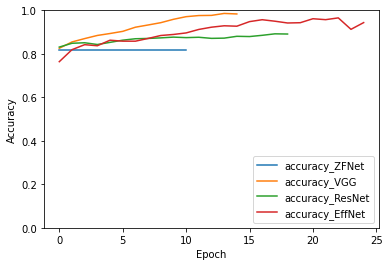

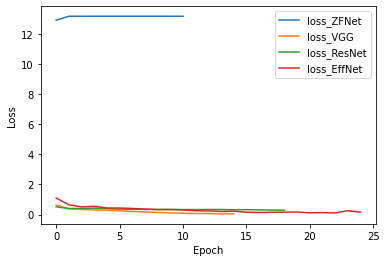

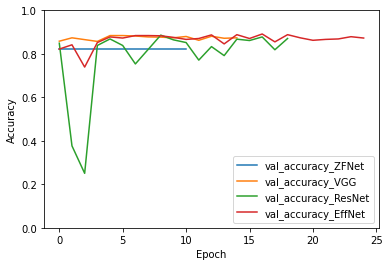

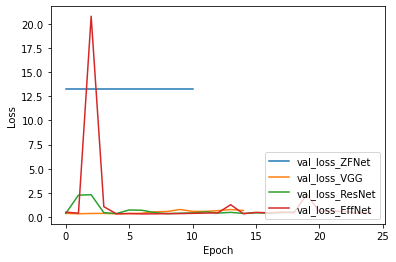

In [ ]:
EPOCHS = 25
setup_experiment(0)

df = pd.read_csv(FILE_PATH, error_bad_lines=False)
df = df.reset_index(drop=True)

train_dataset, valid_dataset, test_dataset = splitt_dataset(df)

train_dataset = train_dataset.reset_index(drop=True)
valid_dataset = valid_dataset.reset_index(drop=True)

images, labels, labelsA = comp_ds2(train_dataset,LABEL_COUNT)
v_images, v_labels, v_labelsA = comp_ds2(valid_dataset,LABEL_COUNT)

train_set = tf.data.Dataset.from_tensor_slices((images.reshape(len(labels),100,140,3),labelsA)).shuffle(1000).batch(32)
valid_set = tf.data.Dataset.from_tensor_slices((v_images.reshape(len(v_labels),100,140,3),v_labelsA)).shuffle(1000).batch(32)

gc.collect()

models = setup_model()

history = train_models(models,EPOCHS)

plot_allhistory(history)

## Multi Brand

---Finished---
---Finished---
Epoch 1/25
240/240 [==============================] - 11s 42ms/step - loss: 10.2563 - accuracy: 0.0816 - val_loss: 12.0673 - val_accuracy: 0.0824
Epoch 2/25
240/240 [==============================] - 9s 37ms/step - loss: 12.0281 - accuracy: 0.0825 - val_loss: 12.0673 - val_accuracy: 0.0824
Epoch 3/25
240/240 [==============================] - 9s 37ms/step - loss: 12.0281 - accuracy: 0.0825 - val_loss: 12.0673 - val_accuracy: 0.0824
Epoch 4/25
240/240 [==============================] - 9s 37ms/step - loss: 12.0281 - accuracy: 0.0825 - val_loss: 12.0673 - val_accuracy: 0.0824
Epoch 5/25
240/240 [==============================] - 9s 37ms/step - loss: 12.0281 - accuracy: 0.0825 - val_loss: 12.0673 - val_accuracy: 0.0824
Epoch 6/25
240/240 [==============================] - 9s 36ms/step - loss: 12.0281 - accuracy: 0.0825 - val_loss: 12.0673 - val_accuracy: 0.0824
Epoch 7/25
240/240 [==============================] - 9s 37ms/step - loss: 12.0281 - accuracy: 0.08

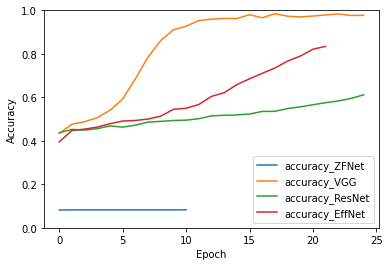

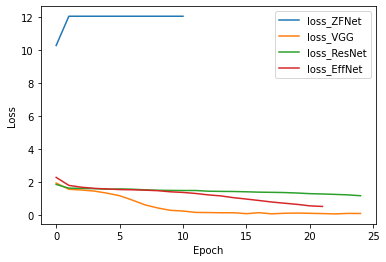

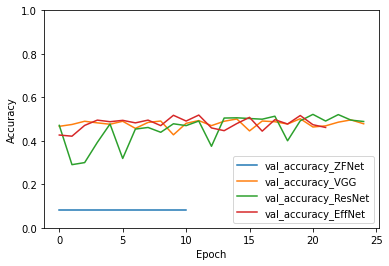

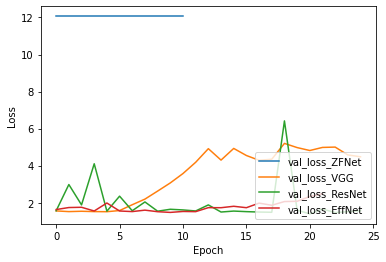

In [ ]:
EPOCHS = 25
setup_experiment(1)

df = pd.read_csv(FILE_PATH, error_bad_lines=False)
df = df.reset_index(drop=True)

train_dataset, valid_dataset, test_dataset = splitt_dataset(df)

train_dataset = train_dataset.reset_index(drop=True)
valid_dataset = valid_dataset.reset_index(drop=True)

images, labels, labelsA = comp_ds2(train_dataset,LABEL_COUNT)
v_images, v_labels, v_labelsA = comp_ds2(valid_dataset,LABEL_COUNT)

train_set = tf.data.Dataset.from_tensor_slices((images.reshape(len(labels),100,140,3),labelsA)).shuffle(1000).batch(32)
valid_set = tf.data.Dataset.from_tensor_slices((v_images.reshape(len(v_labels),100,140,3),v_labelsA)).shuffle(1000).batch(32)

gc.collect()

models = setup_model()

history = train_models(models,EPOCHS)

plot_allhistory(history)

## Apple vs Samsung

---Finished---
---Finished---
Epoch 1/25
240/240 [==============================] - 22s 50ms/step - loss: 6.4358 - accuracy: 0.0748 - val_loss: 6.0592 - val_accuracy: 0.0750
Epoch 2/25
240/240 [==============================] - 9s 38ms/step - loss: 6.0624 - accuracy: 0.0752 - val_loss: 6.0592 - val_accuracy: 0.0750
Epoch 3/25
240/240 [==============================] - 9s 38ms/step - loss: 6.0624 - accuracy: 0.0752 - val_loss: 6.0592 - val_accuracy: 0.0750
Epoch 4/25
240/240 [==============================] - 9s 38ms/step - loss: 6.0624 - accuracy: 0.0752 - val_loss: 6.0592 - val_accuracy: 0.0750
Epoch 5/25
240/240 [==============================] - 9s 38ms/step - loss: 6.0624 - accuracy: 0.0752 - val_loss: 6.0592 - val_accuracy: 0.0750
Epoch 6/25
240/240 [==============================] - 9s 38ms/step - loss: 6.0624 - accuracy: 0.0752 - val_loss: 6.0592 - val_accuracy: 0.0750
Epoch 7/25
240/240 [==============================] - 9s 38ms/step - loss: 6.0624 - accuracy: 0.0752 - val_loss

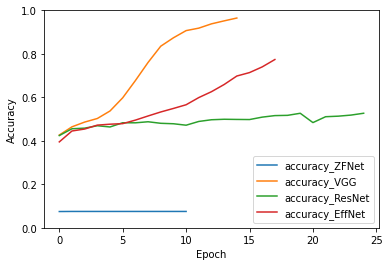

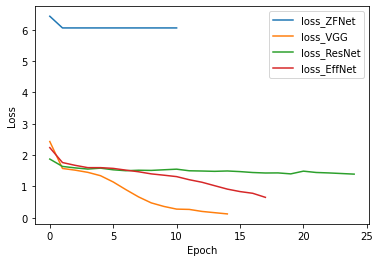

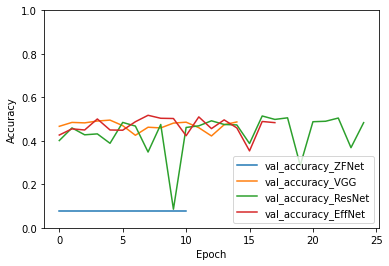

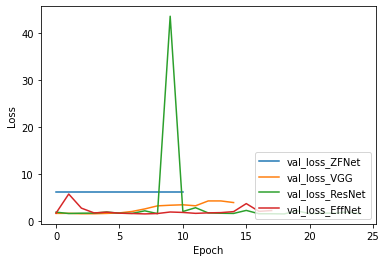

In [ ]:
EPOCHS = 25
setup_experiment(1)

df = pd.read_csv(FILE_PATH, error_bad_lines=False)
df = df.reset_index(drop=True)

train_dataset, valid_dataset, test_dataset = splitt_dataset(df)

train_dataset = train_dataset.reset_index(drop=True)
valid_dataset = valid_dataset.reset_index(drop=True)

images, labels, labelsA = comp_ds2(train_dataset,LABEL_COUNT)
v_images, v_labels, v_labelsA = comp_ds2(valid_dataset,LABEL_COUNT)

train_set = tf.data.Dataset.from_tensor_slices((images.reshape(len(labels),100,140,3),labelsA)).shuffle(1000).batch(32)
valid_set = tf.data.Dataset.from_tensor_slices((v_images.reshape(len(v_labels),100,140,3),v_labelsA)).shuffle(1000).batch(32)

gc.collect()

models = setup_model()

history = train_models(models,EPOCHS)

plot_allhistory(history)

---Finished---
---Finished---
Epoch 1/25
167/167 [==============================] - 8s 45ms/step - loss: 0.6920 - accuracy: 0.6533 - val_loss: 0.6081 - val_accuracy: 0.6913
Epoch 2/25
167/167 [==============================] - 7s 40ms/step - loss: 0.6046 - accuracy: 0.6874 - val_loss: 0.5875 - val_accuracy: 0.6958
Epoch 3/25
167/167 [==============================] - 6s 38ms/step - loss: 0.6380 - accuracy: 0.6510 - val_loss: 0.6656 - val_accuracy: 0.6084
Epoch 4/25
167/167 [==============================] - 6s 38ms/step - loss: 0.6365 - accuracy: 0.6379 - val_loss: 0.6016 - val_accuracy: 0.6792
Epoch 5/25
167/167 [==============================] - 6s 38ms/step - loss: 0.5851 - accuracy: 0.6947 - val_loss: 0.5806 - val_accuracy: 0.6883
Epoch 6/25
167/167 [==============================] - 7s 41ms/step - loss: 0.5698 - accuracy: 0.7048 - val_loss: 0.5582 - val_accuracy: 0.7108
Epoch 7/25
167/167 [==============================] - 7s 40ms/step - loss: 0.5604 - accuracy: 0.7071 - val_loss:

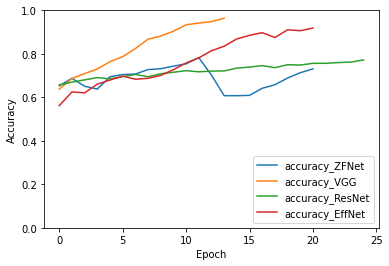

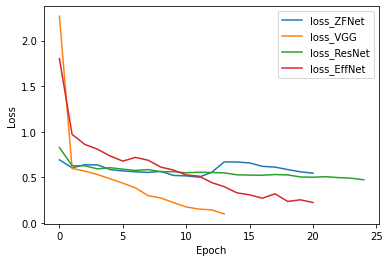

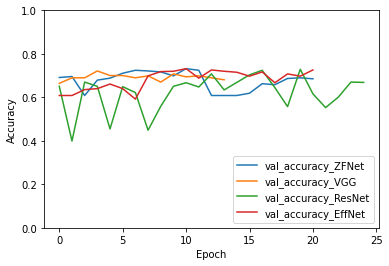

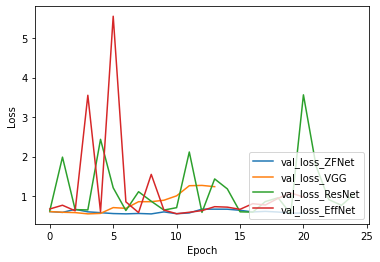

In [ ]:
EPOCHS = 25
setup_experiment(2)

df = pd.read_csv(FILE_PATH, error_bad_lines=False)
df = df.reset_index(drop=True)

train_dataset, valid_dataset, test_dataset = splitt_dataset(df)

train_dataset = train_dataset.reset_index(drop=True)
valid_dataset = valid_dataset.reset_index(drop=True)

images, labels, labelsA = comp_ds2(train_dataset,LABEL_COUNT)
v_images, v_labels, v_labelsA = comp_ds2(valid_dataset,LABEL_COUNT)

train_set = tf.data.Dataset.from_tensor_slices((images.reshape(len(labels),100,140,3),labelsA)).shuffle(1000).batch(32)
valid_set = tf.data.Dataset.from_tensor_slices((v_images.reshape(len(v_labels),100,140,3),v_labelsA)).shuffle(1000).batch(32)

gc.collect()

models = setup_model()

history = train_models(models,EPOCHS)

plot_allhistory(history)

## Apple vs Samsung vs Rest

---Finished---
---Finished---
Epoch 1/25
240/240 [==============================] - 11s 43ms/step - loss: 1.1019 - accuracy: 0.2852 - val_loss: 1.0689 - val_accuracy: 0.2746
Epoch 2/25
240/240 [==============================] - 9s 38ms/step - loss: 1.0790 - accuracy: 0.2799 - val_loss: 1.0589 - val_accuracy: 0.2746
Epoch 3/25
240/240 [==============================] - 10s 40ms/step - loss: 1.0640 - accuracy: 0.2783 - val_loss: 1.0630 - val_accuracy: 0.2798
Epoch 4/25
240/240 [==============================] - 9s 38ms/step - loss: 1.0352 - accuracy: 0.2351 - val_loss: 1.0135 - val_accuracy: 0.2397
Epoch 5/25
240/240 [==============================] - 9s 38ms/step - loss: 0.9977 - accuracy: 0.2129 - val_loss: 0.9920 - val_accuracy: 0.2144
Epoch 6/25
240/240 [==============================] - 9s 38ms/step - loss: 1.0006 - accuracy: 0.2071 - val_loss: 0.9950 - val_accuracy: 0.2239
Epoch 7/25
240/240 [==============================] - 9s 38ms/step - loss: 0.9845 - accuracy: 0.1962 - val_los

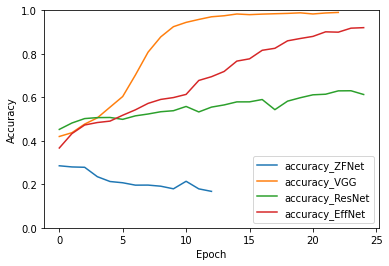

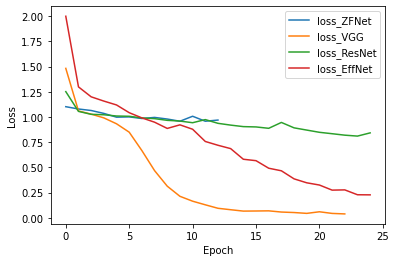

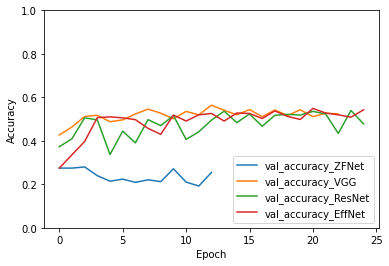

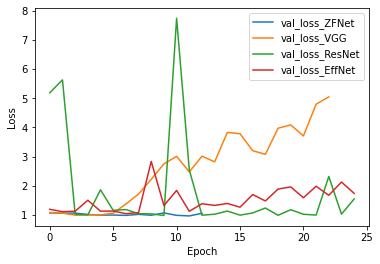

In [ ]:
EPOCHS = 25
setup_experiment(3)

df = pd.read_csv(FILE_PATH, error_bad_lines=False)
df = df.reset_index(drop=True)

train_dataset, valid_dataset, test_dataset = splitt_dataset(df)

train_dataset = train_dataset.reset_index(drop=True)
valid_dataset = valid_dataset.reset_index(drop=True)

images, labels, labelsA = comp_ds2(train_dataset,LABEL_COUNT)
v_images, v_labels, v_labelsA = comp_ds2(valid_dataset,LABEL_COUNT)

train_set = tf.data.Dataset.from_tensor_slices((images.reshape(len(labels),100,140,3),labelsA)).shuffle(1000).batch(32)
valid_set = tf.data.Dataset.from_tensor_slices((v_images.reshape(len(v_labels),100,140,3),v_labelsA)).shuffle(1000).batch(32)

gc.collect()

models = setup_model()

history = train_models(models,EPOCHS)

plot_allhistory(history)

## Apple vs Rest

---Finished---
---Finished---
Epoch 1/25
240/240 [==============================] - 11s 42ms/step - loss: 9.2916 - accuracy: 0.5766 - val_loss: 9.2420 - val_accuracy: 0.5734
Epoch 2/25
240/240 [==============================] - 9s 38ms/step - loss: 9.2936 - accuracy: 0.5766 - val_loss: 9.2419 - val_accuracy: 0.5734
Epoch 3/25
240/240 [==============================] - 9s 38ms/step - loss: 9.2936 - accuracy: 0.5766 - val_loss: 9.2419 - val_accuracy: 0.5734
Epoch 4/25
240/240 [==============================] - 9s 38ms/step - loss: 9.2936 - accuracy: 0.5766 - val_loss: 9.2419 - val_accuracy: 0.5734
Epoch 5/25
240/240 [==============================] - 9s 38ms/step - loss: 9.2936 - accuracy: 0.5766 - val_loss: 9.2420 - val_accuracy: 0.5734
Epoch 6/25
240/240 [==============================] - 9s 38ms/step - loss: 9.2936 - accuracy: 0.5766 - val_loss: 9.2419 - val_accuracy: 0.5734
Epoch 7/25
240/240 [==============================] - 9s 38ms/step - loss: 9.2936 - accuracy: 0.5766 - val_loss

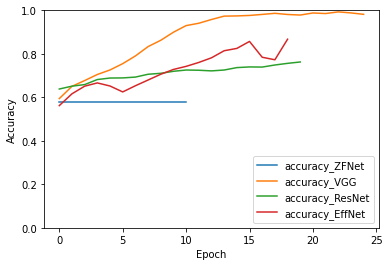

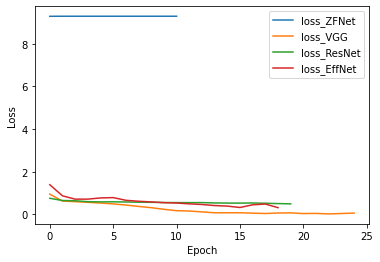

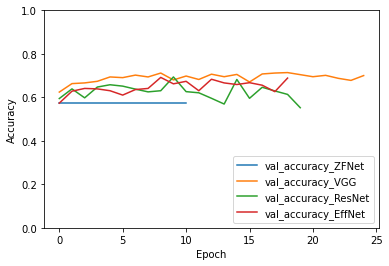

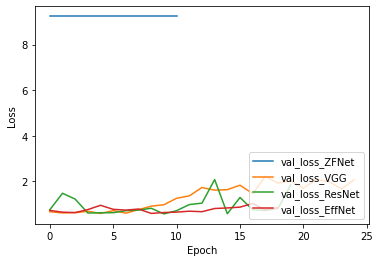

In [ ]:
EPOCHS = 25
setup_experiment(4)

df = pd.read_csv(FILE_PATH, error_bad_lines=False)
df = df.reset_index(drop=True)

train_dataset, valid_dataset, test_dataset = splitt_dataset(df)

train_dataset = train_dataset.reset_index(drop=True)
valid_dataset = valid_dataset.reset_index(drop=True)

images, labels, labelsA = comp_ds2(train_dataset,LABEL_COUNT)
v_images, v_labels, v_labelsA = comp_ds2(valid_dataset,LABEL_COUNT)

train_set = tf.data.Dataset.from_tensor_slices((images.reshape(len(labels),100,140,3),labelsA)).shuffle(1000).batch(32)
valid_set = tf.data.Dataset.from_tensor_slices((v_images.reshape(len(v_labels),100,140,3),v_labelsA)).shuffle(1000).batch(32)

gc.collect()

models = setup_model()

history = train_models(models,EPOCHS)

plot_allhistory(history)

##Samsung vs Rest

---Finished---
---Finished---
Epoch 1/25
240/240 [==============================] - 11s 43ms/step - loss: 9.6266 - accuracy: 0.3394 - val_loss: 11.6929 - val_accuracy: 0.7254
Epoch 2/25
240/240 [==============================] - 9s 38ms/step - loss: 11.7102 - accuracy: 0.7265 - val_loss: 11.6929 - val_accuracy: 0.7254
Epoch 3/25
240/240 [==============================] - 9s 38ms/step - loss: 11.7102 - accuracy: 0.7265 - val_loss: 11.6929 - val_accuracy: 0.7254
Epoch 4/25
240/240 [==============================] - 9s 38ms/step - loss: 11.7102 - accuracy: 0.7265 - val_loss: 11.6929 - val_accuracy: 0.7254
Epoch 5/25
240/240 [==============================] - 9s 38ms/step - loss: 11.7102 - accuracy: 0.7265 - val_loss: 11.6929 - val_accuracy: 0.7254
Epoch 6/25
240/240 [==============================] - 9s 38ms/step - loss: 11.7102 - accuracy: 0.7265 - val_loss: 11.6929 - val_accuracy: 0.7254
Epoch 7/25
240/240 [==============================] - 9s 38ms/step - loss: 11.7102 - accuracy: 0.726

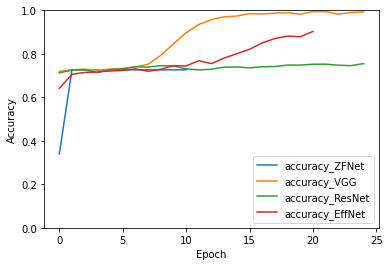

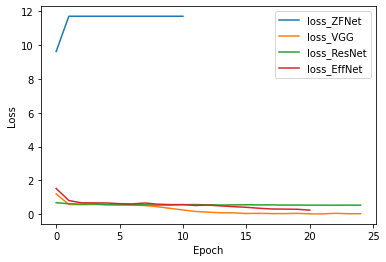

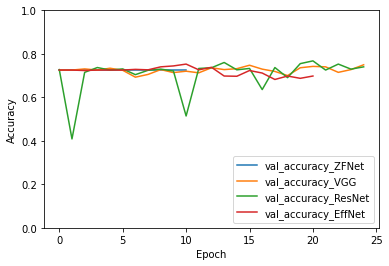

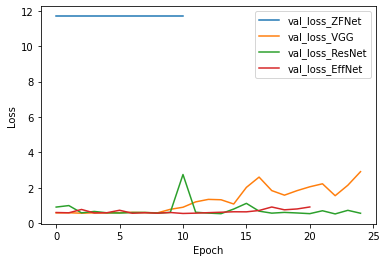

In [ ]:
EPOCHS = 25
setup_experiment(5)

df = pd.read_csv(FILE_PATH, error_bad_lines=False)
df = df.reset_index(drop=True)

train_dataset, valid_dataset, test_dataset = splitt_dataset(df)

train_dataset = train_dataset.reset_index(drop=True)
valid_dataset = valid_dataset.reset_index(drop=True)

images, labels, labelsA = comp_ds2(train_dataset,LABEL_COUNT)
v_images, v_labels, v_labelsA = comp_ds2(valid_dataset,LABEL_COUNT)

train_set = tf.data.Dataset.from_tensor_slices((images.reshape(len(labels),100,140,3),labelsA)).shuffle(1000).batch(32)
valid_set = tf.data.Dataset.from_tensor_slices((v_images.reshape(len(v_labels),100,140,3),v_labelsA)).shuffle(1000).batch(32)

gc.collect()

models = setup_model()

history = train_models(models,EPOCHS)

plot_allhistory(history)

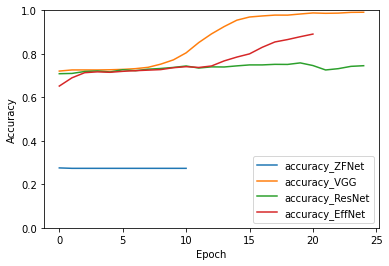

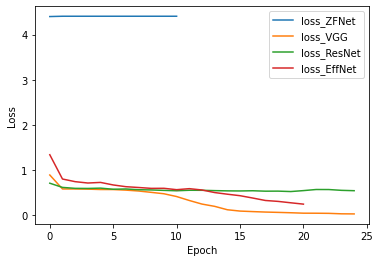

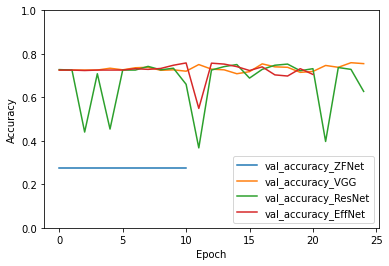

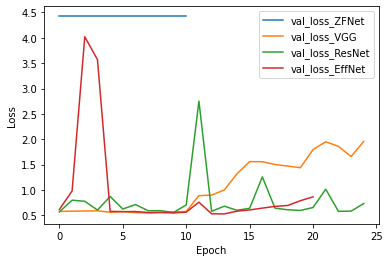

In [ ]:
plot_allhistory(history)